# Hierarchical Alternating Least Squares (HALS)

In [0]:
import os
import glob
import imageio
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## HALS

In [0]:
def HALS_original(V, k0, max_iters):

	# Dimensions
	(m, n) = V.shape

	# Initialize W, H
	W = np.random.uniform(low=0.0, high=1.0, size=(m, k0))
	H = np.random.uniform(low=0.0, high=1.0, size=(n, k0))

	# Normalize columns
	W = normalize(W, axis=0, norm='l2')
	H = normalize(H, axis=0, norm='l2')

	# Set reconstruction error
	E = V - W @ H.T

	loss = [0.5 * float(np.linalg.norm(V - W @ H.T)) / np.linalg.norm(V)]

	for t in range(max_iters):

		for j in range(k0):
      
			wj = W[:, j]
			hj = H[:, j]

			# Compute smart error
			Vj = E + np.outer(wj, hj)
         
			# Compute hj
			hj = Vj.T @ wj
			hj = np.clip(hj, 0.0, np.Inf)

			# Compute wj
			wj = Vj @ hj
			wj = np.clip(wj, 0.0, np.Inf)
			norm = np.linalg.norm(wj)
			wj *= (1.0 / (norm + 1.0e-12))
   
            # Update values
			E = Vj - np.outer(wj, hj)
			W[:, j] = wj[:]
			H[:, j] = hj[:]

        # Keep track error
		loss.append(0.5 * float(np.linalg.norm(V - W @ H.T)) / np.linalg.norm(V) )

	return {
		  'W': W,
		  'H': H,
		  'loss':loss
	}

## Experiment 01 (Synthetic data)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
V = np.loadtxt('/content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Synthetic/V_30x30_5.txt')

In [0]:
maxV = np.max(np.abs(V))
V = (1.0 / maxV) * V

In [0]:
result = HALS_original(V, 10, 100)

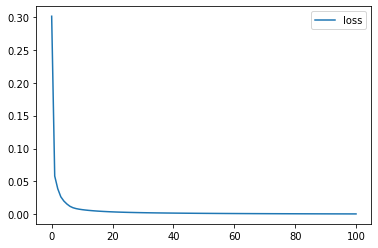

In [9]:
plt.plot(result['loss'], label='loss')
plt.legend()

## Experiment 02 (Swimmer dataset)

In [0]:
def ReadImgs(pathIn):

    # read the name of the image file
    filesSwimmer = glob.glob(os.path.join(pathIn, '*' + '.png'))

    # define dimensions
    img0 = imageio.imread(filesSwimmer[0]).astype('float64')

    # get dimensions
    r, c = img0.shape

    # define matrix
    A = np.zeros((r * c, len(filesSwimmer)))

    # load all frames
    for i in range(len(filesSwimmer)):
        img = imageio.imread(filesSwimmer[i]).astype('float64')
        A[:, i] = img.flatten()
        print('read: ', filesSwimmer[i])

    # Make A_ij \in [0,1]
    maxA = np.max(np.abs(A))
    A = (1.0 / maxA) * A

    return A


In [11]:
V = ReadImgs('/content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer')

read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/97.png
read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/154.png
read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/223.png
read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/55.png
read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/68.png
read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/145.png
read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/151.png
read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/6.png
read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/54.png
read:  /content/drive/My Drive/Taller_DeepLearning_STARTER/Taller01_Starter/data/Swimmer/96.png
read:  /content/drive/My Drive/Taller

In [0]:
result = HALS_original(V, 24, 100)

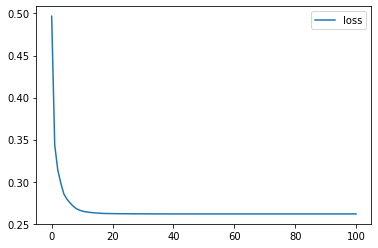

In [19]:
plt.plot(result['loss'], label='loss')
plt.legend()

In [0]:
def PlotBasis(result):

    W = result['W']

    fig1, ax1 = plt.subplots(nrows=4, ncols=5, figsize=(12, 10))

    for i in range(4):
        for j in range(5):
            ax1[i, j].axis('off')
            ax1[i, j].grid(False)
            ax1[i, j].set_xticks([])
            ax1[i, j].set_yticks([])

    index = 0;
    for i in range(4):
        for j in range(5):

            ax1[i, j].imshow(W[:, index].reshape(32, 32),cmap='gray' )
            index += 1

            if index == 24:
                break
    
    return fig1, ax1

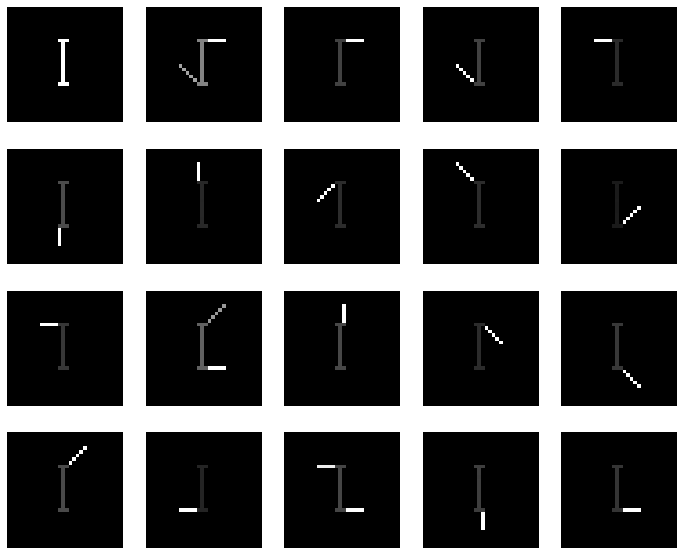

In [24]:
fig1, ax1 = PlotBasis(result)

In [0]:
def PlotPCA(V):
    u, s, vt = np.linalg.svd(V)
    rankV = np.sum(np.abs(s) > 1e-9)
    print('Rank: ', rankV)

    pca = PCA(n_components=rankV, svd_solver='randomized', whiten=True).fit(V.T)
    eigenW = pca.components_.reshape((rankV, 32, 32))

    fig1, ax1 = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))

    for i in range(4):
        for j in range(4):
            ax1[i, j].axis('off')
            ax1[i, j].grid(False)
            ax1[i, j].set_xticks([])
            ax1[i, j].set_yticks([])

    index = 0
    for i in range(4):
        for j in range(4):

            ax1[i, j].imshow(eigenW[index, :, :], cmap='RdBu')
            index += 1

            if index == rankV:
                break

    return fig1, ax1

Rank:  13


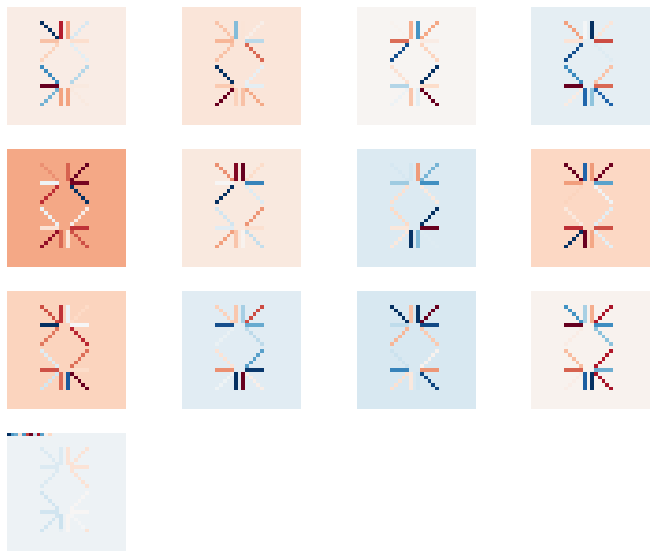

In [17]:
fig1, ax1 = PlotPCA(V)